In [1]:
import torch
import matplotlib.pyplot as plt
import sys
from neuralop.models import SFNO
from neuralop import Trainer
from neuralop.datasets import load_spherical_swe
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device('cuda:0')

In [5]:
train_loader, test_loaders = load_spherical_swe(n_train=200, batch_size=4, train_resolution=(32, 64),
                                                test_resolutions=[(32, 64), (64, 128)], n_tests=[50, 50], test_batch_sizes=[10, 10],)

Loading train dataloader at resolution (32, 64) with 200 samples and batch-size=4
Loading test dataloader at resolution (32, 64) with 50 samples and batch-size=10
Loading test dataloader at resolution (64, 128) with 50 samples and batch-size=10


In [6]:
model = SFNO(n_modes=(32, 32), in_channels=3, out_channels=3, hidden_channels=32, projection_channels=64, factorization='dense')
model = model.to(device)

n_params = count_model_params(model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()


Our model has 277923 parameters.


In [7]:
optimizer = torch.optim.Adam(model.parameters(),
                                lr=8e-4,
                                weight_decay=0.0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

In [8]:
l2loss = LpLoss(d=2, p=2, reduce_dims=(0,1))
# h1loss = H1Loss(d=2, reduce_dims=(0,1))

train_loss = l2loss
eval_losses={'l2': l2loss} #'h1': h1loss,

In [9]:
print('\n### MODEL ###\n', model)
print('\n### OPTIMIZER ###\n', optimizer)
print('\n### SCHEDULER ###\n', scheduler)
print('\n### LOSSES ###')
print(f'\n * Train: {train_loss}')
print(f'\n * Test: {eval_losses}')
sys.stdout.flush()


### MODEL ###
 SFNO(
  (fno_blocks): FNOBlocks(
    (convs): SphericalConv(
      (weight): ModuleList(
        (0-3): 4 x ComplexDenseTensor(shape=torch.Size([32, 32, 32]), rank=None)
      )
      (sht_handle): SHT(
        (_SHT_cache): ModuleDict()
        (_iSHT_cache): ModuleDict()
      )
    )
    (fno_skips): ModuleList(
      (0-3): 4 x Flattened1dConv(
        (conv): Conv1d(32, 32, kernel_size=(1,), stride=(1,), bias=False)
      )
    )
  )
  (lifting): MLP(
    (fcs): ModuleList(
      (0): Conv1d(3, 256, kernel_size=(1,), stride=(1,))
      (1): Conv1d(256, 32, kernel_size=(1,), stride=(1,))
    )
  )
  (projection): MLP(
    (fcs): ModuleList(
      (0): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (1): Conv1d(64, 3, kernel_size=(1,), stride=(1,))
    )
  )
)

### OPTIMIZER ###
 Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.000

In [10]:
trainer = Trainer(model=model, n_epochs=20,
                  device=device,
                  wandb_log=False,
                  log_test_interval=3,
                  use_distributed=False,
                  verbose=True)

self.override_load_to_device=False
self.overrides_loss=False


In [11]:
trainer.train(train_loader=train_loader,
              test_loaders=test_loaders,
              optimizer=optimizer,
              scheduler=scheduler,
              regularizer=False,
              training_loss=train_loss,
              eval_losses=eval_losses)

{'(64, 128)_l2': 2.373329772949219}

/tmp/ipykernel_13199/3756923437.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


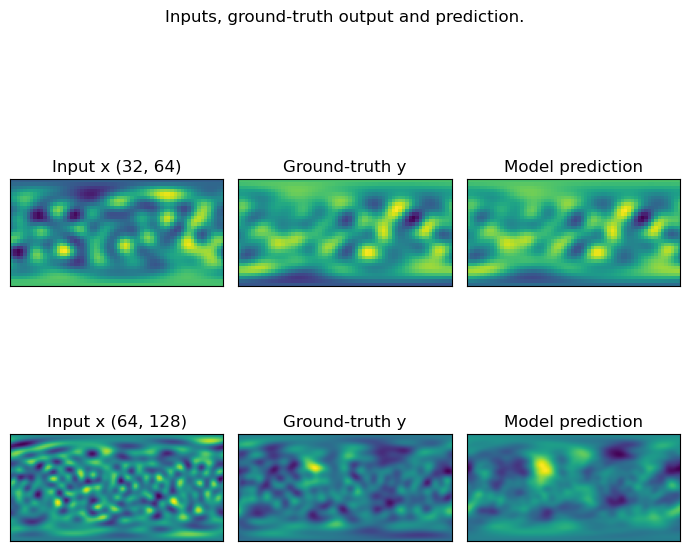

In [13]:
fig = plt.figure(figsize=(7, 7))
for index, resolution in enumerate([(32, 64), (64, 128)]):
    test_samples = test_loaders[resolution].dataset
    data = test_samples[0]
    # Input x
    x = data['x']
    # Ground-truth
    y = data['y'][0, ...].numpy()
    # Model prediction
    x_in = x.unsqueeze(0).to(device)
    out = model(x_in).squeeze()[0, ...].detach().cpu().numpy()
    x = x[0, ...].detach().numpy()

    ax = fig.add_subplot(2, 3, index*3 + 1)
    ax.imshow(x)
    ax.set_title(f'Input x {resolution}')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(2, 3, index*3 + 2)
    ax.imshow(y)
    ax.set_title('Ground-truth y')
    plt.xticks([], [])
    plt.yticks([], [])

    ax = fig.add_subplot(2, 3, index*3 + 3)
    ax.imshow(out)
    ax.set_title('Model prediction')
    plt.xticks([], [])
    plt.yticks([], [])

fig.suptitle('Inputs, ground-truth output and prediction.', y=0.98)
plt.tight_layout()
fig.show()
